In [1]:
import jsonlines
import json
from tqdm import tqdm
import glob
import re

In [2]:
path_list = glob.glob('data/final_features/*.jsonl')
path_list = sorted(path_list)

In [10]:
reg = re.compile(r'([0-9]+)')

In [ ]:
# inteiro_teor_list = []
# for path in path_list:
#     year = reg.search(path).group(1)
#     print('Running ' + year + '...')
#     with jsonlines.open(path) as reader:
#         for obj in tqdm(reader):
#             inteiro_teor_list.append(obj['inteiro_teor'])

In [11]:
from syntok.tokenizer import Tokenizer

In [12]:
tok = Tokenizer()

In [13]:
with open('corpus.txt', 'a+', encoding='utf-8') as f:
    for path in path_list:
        year = reg.search(path).group(1)
        print('Running ' + year + '...')
        with jsonlines.open(path) as reader:
            for obj in tqdm(reader):
                inteiro_teor_tokens = []
                for token in tok.tokenize(obj['inteiro_teor'].lower()):
                    f.write(token.value + ' ')
                f.write('\n')

0it [00:00, ?it/s]

Running 2010...


130534it [22:01, 98.75it/s]
9it [00:00, 89.11it/s]

Running 2011...


139185it [29:01, 79.90it/s]
2it [00:00, 18.91it/s]

Running 2012...


119398it [23:54, 83.25it/s]
10it [00:00, 86.15it/s]

Running 2013...


131581it [27:53, 78.65it/s]
9it [00:00, 87.92it/s]

Running 2014...


146430it [35:02, 69.63it/s]
1it [00:00,  6.68it/s]

Running 2016...


119007it [24:35, 80.64it/s] 


In [2]:
import numpy as np

In [4]:
# sentences = []
# for tokenized_inteiro_teor in all_inteiro_teor_tokens:
#     length = int(len(tokenized_inteiro_teor)/100) + 1
#     chunks = np.array_split(tokenized_inteiro_teor, length)
#     for c in chunks:
#         sentences.append(c.tolist())

In [3]:
import gensim
from gensim.models import Word2Vec
import multiprocessing

In [4]:
data = gensim.models.word2vec.LineSentence('corpus.txt')

In [5]:
%time model = Word2Vec(data, size=50, window=5, min_count=3, workers=multiprocessing.cpu_count())

CPU times: user 4h 58min 58s, sys: 2min 34s, total: 5h 1min 33s
Wall time: 1h 43min 15s


In [8]:
model.wv.most_similar('parágrafo', topn=25)

[('§', 0.7885379195213318),
 ('paragrafo', 0.6839940547943115),
 ('§§', 0.5672340393066406),
 ('paragráfo', 0.5436819791793823),
 ('parágrago', 0.5433307886123657),
 ('parág', 0.5314463376998901),
 ('parágrafos', 0.5278464555740356),
 ('parágafo', 0.5212037563323975),
 ('parégrafo', 0.5155393481254578),
 ('sofreu.parágrafo', 0.5142350196838379),
 ('páragrafo', 0.5142165422439575),
 ('caput', 0.5101661682128906),
 ('prágrafo', 0.4844208061695099),
 ("'parágrafo", 0.4769571125507355),
 ('parágráfo', 0.4737931787967682),
 ('(§', 0.47310081124305725),
 ('parágravo', 0.46928784251213074),
 ('paráqrafo', 0.4686627984046936),
 ('licc', 0.46328204870224),
 ('dano.parágrafo', 0.44151413440704346),
 ('arágrafo', 0.43636059761047363),
 ('paráfrafo', 0.4289481043815613),
 ('ágrafo', 0.4248163104057312),
 ('art', 0.4229249060153961),
 ('pár', 0.42166656255722046)]

In [21]:
keys = ['parágrafo', 'acordão', 'indeferido']

In [22]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=28):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/home/thiago/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [23]:
from sklearn.manifold import TSNE

In [24]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


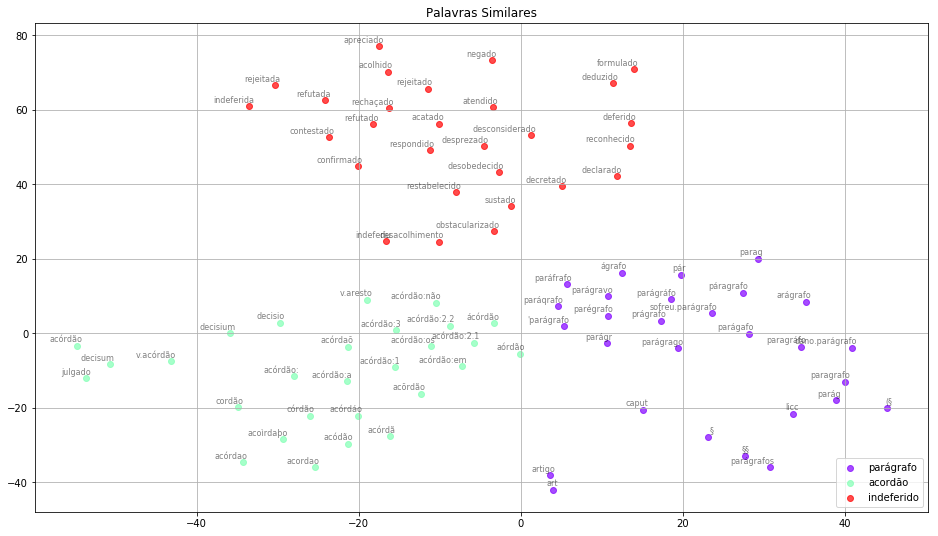

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Palavras Similares', keys, embeddings_en_2d, word_clusters, 0.7, 'similar_words.png')

In [6]:
import tensorflow as tf

In [7]:
embeddings = {}
for word in model.wv.vocab.keys():
    embeddings[word] = model.wv.word_vec(word)

In [8]:
def write_embeddings_file(embeddings, filename):
    with open(filename, 'a+', encoding='utf-8') as f:
        for word in tqdm(list(embeddings.keys())):
            line = word + ' '
            for e in embeddings[word].tolist():
                line += str(e) + ' '
            line = line.strip()
            f.write(line + '\n')

In [9]:
write_embeddings_file(embeddings, 'word_embeddings/w2v_50.txt')

100%|██████████| 623264/623264 [00:29<00:00, 20953.89it/s]


In [37]:
def create_model_variables(embeddings, path_name, tensor_name):
    embeddings_vectors = np.stack(list(embeddings.values()), axis=0)
    emb_vars = tf.Variable(embeddings_vectors, name=tensor_name)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    with tf.Session() as s:
        s.run(init)
        save_path = saver.save(s, path_name)
        print('Modelo salvo no diretório:', save_path)

In [38]:
create_model_variables(embeddings, 'new_model_dir/w2v_300.ckpt', 'word_embeddings')

Modelo salvo no diretório: new_model_dir/w2v_300.ckpt


In [39]:
import os

In [40]:
def create_tsv_vocab(folder):
    words = '\n'.join(list(embeddings.keys()))
    path = os.path.join(folder, 'metadata.tsv')
    with open(path, 'w', encoding='utf-8') as f:
        f.write(words)

In [41]:
create_tsv_vocab('new_model_dir')

Embeddings de apenas palavras

In [42]:
from operator import itemgetter

In [43]:
sorted_embeddings = sorted(embeddings.items(), key=itemgetter(0))
any_words_embedding = {}
for index, we in enumerate(sorted_embeddings[364024:]):    
    any_words_embedding[we[0]] = we[1]

In [ ]:
create_model_variables(any_words_embedding, 'new_words_model_dir/w2v_words_300.ckpt', 'word_embedding_any_w')

In [ ]:
create_tsv_vocab('new_words_model_dir')

In [ ]:
len(any_words_embedding)